In [1]:
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow, legend, show, figure
from keras_lr_finder import LRFinder  

print(tf.version.VERSION)
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

2.3.2
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
lesions = {0: "Basal Cell Carcinoma", 
    1: "Lentigo",
    2: "Malignant Melanoma", 
    3: "Melanocytic naevus",
    4: "seborrhoeic keratosis",
    5: "Wart", 
    6: "Actinic Keratosis",
    7: "Squamous Cell Carcinoma",
    8: "Intraepithelial Carcinoma", 
    9: "Pyogenic Granuloma",
    10: "Haemangioma",
    11: "Dermatofibroma"
}

In [3]:
src_path_train = "dataset-split/test/"
def my_preprocessing_func(img):
    image = np.array(img)
    image = image / .8
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=my_preprocessing_func).flow_from_directory(
    directory=src_path_train,
    subset='training',
    class_mode="sparse",
    batch_size=21,
    target_size=(224, 224),
    shuffle=True,
    seed=42
)

Found 7050 images belonging to 12 classes.


In [4]:
src_path_val = "dataset-split/val/"
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=my_preprocessing_func).flow_from_directory(
    directory=src_path_val,
    target_size=(224, 224),
    batch_size=21,
    class_mode="sparse",
    shuffle=True,
    seed=42
)

Found 6570 images belonging to 12 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

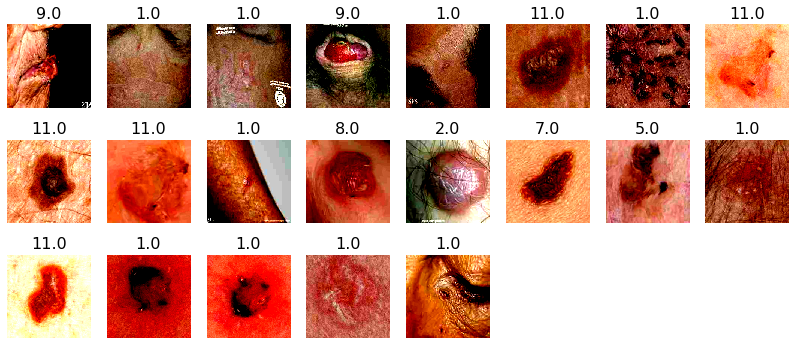

In [5]:
def plots(ims, figsize=(14,6), rows=3, interp=False, titles='lesions'):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        imshow(ims[i], interpolation=None if interp else 'none')
        
imgs, labels = next(train_generator)

plots(imgs, titles=labels)

In [6]:
# src_path_test = "dataset-split/test/"
# test_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
#     directory=src_path_test,
#     target_size=(224, 224),
#     color_mode="rgb",
#     batch_size=1,
#     class_mode=None,
#     shuffle=False,
#     seed=42
# )

In [7]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
# imshow(tf.cast(images_val[5], tf.uint8))

In [9]:
model = tf.keras.applications.ResNet152V2(input_shape=(224,224,3), weights=None, classes=12)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()
# lr_finder = LRFinder(model)
# lr_finder.find(x, y, start_lr=0.006, end_lr=1, batch_size=28, epochs=25)
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=25)

Epoch 1/25
336/336 [==============================] - ETA: 0s - batch: 167.5000 - size: 20.9821 - loss: 2.0143 - acc: 0.3533WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
336/336 [==============================] - 202s 602ms/step - batch: 167.5000 - size: 20.9821 - loss: 2.0143 - acc: 0.3533 - val_loss: 2.0386 - val_acc: 0.3388
Epoch 2/25
336/336 [==============================] - 201s 597ms/step - batch: 167.5000 - size: 20.9821 - loss: 1.5751 - acc: 0.4557 - val_loss: 5.5174 - val_acc: 0.2554
Epoch 3/25
336/336 [==============================] - 201s 597ms/step - batch: 167.5000 - size: 20.9821 - loss: 1.3467 - acc: 0.5167 - val_loss: 4.0048 - val_acc: 0.2355
Epoch 4/25
336/336 [===

In [10]:
# model.save('model/tensorflow-model')

In [11]:
history.history

{'loss': [2.014121216713114,
  1.574744693421303,
  1.3468358234141735,
  1.1419107902303656,
  0.9837954812227412,
  0.9036442572766162,
  0.6926137116424581,
  0.5498876180927804,
  0.4631970232915371,
  0.3507350634989586,
  0.2842810559320323,
  0.25718248173753,
  0.2219918833019093,
  0.16800443916145633,
  0.1533403182715336,
  0.1727211603131938,
  0.11629624143574743,
  0.11652587015999163,
  0.10034763735471333,
  0.10833797492394026,
  0.09667462222213719,
  0.08663447298637116,
  0.07134494929168214,
  0.08201272977973047,
  0.08910654435232727],
 'acc': [0.35333332,
  0.45574468,
  0.5167376,
  0.5807092,
  0.63588655,
  0.68070924,
  0.75333333,
  0.8046808,
  0.8390071,
  0.87787235,
  0.9,
  0.91205674,
  0.9248227,
  0.9428369,
  0.9469504,
  0.9432624,
  0.96340424,
  0.9625532,
  0.96695036,
  0.9641135,
  0.9662411,
  0.97333336,
  0.9778723,
  0.97205675,
  0.97248226],
 'val_loss': [2.038608058572958,
  5.517375936904274,
  4.004764717607833,
  2.1833709284139515,

In [12]:
model.metrics_names

['loss', 'acc']

In [13]:
# model.save_weights('model/tensorflow-model-weights')

In [14]:
try:
    import shap
except Exception as error:
    !pip install {str(error)[17:-1]}
    import shap
except:
    print("Pacote não encontrado")

                                                  id  label
0  dataset-split/train/Wart/Wart_original_100.jpg...      5
1  dataset-split/train/Wart/Wart_original_37.jpg_...      5
2  dataset-split/train/Wart/Wart_original_2.jpg_4...      5
3  dataset-split/train/Wart/Wart_original_21.jpg_...      5
4  dataset-split/train/Wart/Wart_original_54.jpg_...      5
dataset-split/train/Wart/Wart_original_100.jpg_b1cf4712-7089-44ae-8b03-35dfc95d4325.jpg
uint8
dataset-split/train/Wart/Wart_original_37.jpg_4b8537e9-0e10-4865-a920-a5de64cb0392.jpg
uint8


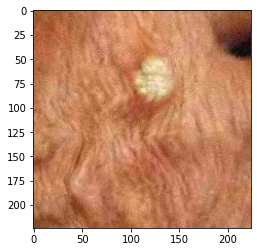

In [23]:
from PIL import Image
from numpy import asarray
import pandas as pd
test = pd.read_csv('train.csv',index_col=0)
print(test.head())
df_test = pd.DataFrame(test)
test_dataset_filenames = df_test['id'].values.tolist()
test_dataset_filenames = test_dataset_filenames[:2]

numpy_images = []
for image in test_dataset_filenames:
    print(image)
    image = Image.open(image)
    image = asarray(image)
    print(image.dtype)
    image = image.astype(np.float32)
    image /= 255
    numpy_images.append(image)
    
x = asarray(numpy_images)
imshow(numpy_images[0])

In [24]:
print(x.shape[0])

background = x[np.random.choice(x.shape[0], 2)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)


2


In [25]:
shap_values = e.shap_values(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


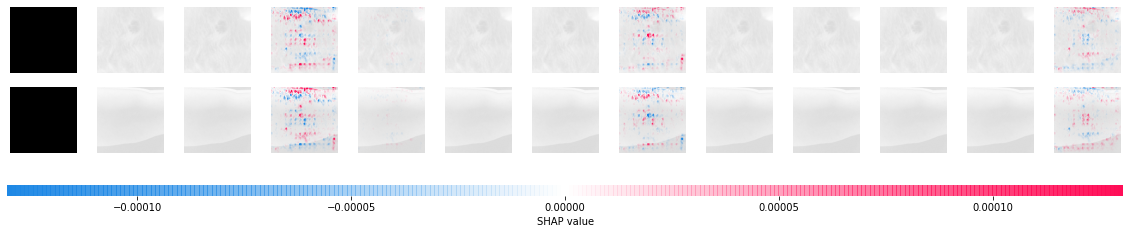

In [26]:
# plot the feature attributions
shap.image_plot(shap_values, -x)

In [ ]:
model.save('model/tensorflow-model-low-test')